# The introductory computer exercise using Python and the SUND toolbox

This version of the exercise is implemented as a Python version using the SUND toolbox, running in an iPython notebook. The notebook can either be [run online in Google colab](https://colab.research.google.com/drive/1y37yYcxwSj5yd0yUePGxtvXZhJNkxf_-?usp=sharing), or <a href="https://isbgroup.eu/edu/courses/intro/computer_exercise/python_sund.ipynb" download>downloaded</a> and run locally.

Note: if running in Google colab, your downloaded and created files will be deleted after you close the session. If you decide to use it, make sure that you download backups! Furthermore, the first thing you should do is to save a copy of the notebook. To do this, press `File > Save a copy in Drive`.

## Introduction

### Purpose of the lab

This lab will on a conceptual level guide you through all the main sub-tasks in a systems biology project: model creation, model training using experimental data, model evaluation, and finally using the model to make predictions of new experiments.

This is an example of the steps the students should do in the exercise, but here implemented in Python. Step 0 revolves around setting up the environment, which will of course be very different when running in system modeller. In this example, I will lump together quite a lot of steps since they will most likely be completely different in the system modeller implementation

## Step 0: Setting up the environment

<details class="admonition success"><summary> Setting up the simulation toolbox</summary>

First make sure that you have a c-compiler installed. If you are running a unix-based operating system such as Mac OS or Linux you will have c-compiler already installed.

For Windows users you will need to install a c-compiler, for the newer Python distribution (version > 3.4) you will need to install the Microsoft Visual C++ compiler (MSVC). This can either be installed as a part of Visual Studios or as a standalone installation using Visual Studios Build Tools. [Here](https://wiki.python.org/moin/WindowsCompiler) can you see which compiler you need for your Python installations and follow the links to install the compiler.

Make sure you have pip (the Python package installer) installed: From the terminal (Unix-users) or command window (Windows-users) try running `pip --version` (Linux users may have to write `pip3`). If `pip` is not installed, follow instructions [here](https://packaging.python.org/tutorials/installing-packages/) to install it.

When you have ensured that pip is installed, check that setuptools are installed by running `pip show setuptools`. If installed it should show information about the setuptools package, such as version number. If not installed you can install it using pip: `pip install setuptools`.

After that you also need to install `numpy`, `matplotlib`, `jupyter` and the [`SUND toolbox`](https://isbgroup.eu/edu/assets/sund-1.0.3.1.tar.gz). The easiest way is to install the packages using `pip install ...` (e.g., `pip install numpy matplotlib jupyter https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz`).

</details>

Note, if running on Google Colab, you must use the cell below, and the packages will only be installed on the remote connection, not on your local computer. 

You can also use this cell if running the notebook on your own computer, but be aware that it will install packages in the current environment.

In [2]:
# Installing packages. Warning, this code cell will install packages to your computer.
%pip install numpy matplotlib jupyter
%pip install https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz

Note: you may need to restart the kernel to use updated packages.
  Using cached https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz (531 kB)
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import packages
import sys
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import sund
import json
from scipy.stats import chi2
from scipy.optimize import Bounds
from scipy.optimize import differential_evolution
import csv
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Setup numpy -> json encoder (might not be needed)
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

Download the data

In [4]:
# Download the experimental data:
#!curl https://isbgroup.eu/edu/assets/Intro/Files/data_2024-03-12.json > data_2024-03-12.json

## Step 1: Implement a minimal model to get familiar with the software

Implement a first minimal model for NFKB activation
(This will most likely be given to the students, so that they have something to start with, to understand the basics of the software)

This is the model to implement: 

![simple_model](assets/simple_model.svg)

In this version, these are the ODEs used: 

```c

########## STATES
d/dt(NFKBinactive) = -vact + vinact
d/dt(NFKBactive)   =  vact - vinact

NFKBinactive(0)=100
NFKBactive(0)=0

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1

########## VARIABLES
vact   = LPS * NFKBinactive * k1 
vinact = NFKBactive * k2 

```

Make a first simulation, play around with changing the parameter values and simulation length.

(change time in the code to change the simulated time)

In [5]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple.txt')
Simple = sund.importModel('simple')
simple = Simple() # get the object from the model class

# Define functions to simulate and plot the simulation
def plot_feature(simulation, featurename):
    plt.plot(simulation['time'], simulation[featurename])
    plt.xlabel('Time')
    plt.ylabel('Response (a.u.)')
    plt.title(featurename)

def simulate_and_plot(simulation, time, params=[1,2], features_to_plot = None):
    if features_to_plot is None:
        features_to_plot = simulation.featurenames

    simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=params)
    feature_data = simulation.featuredata_dict()
    feature_data["time"] = simulation.timevector

    for feature in features_to_plot:
        plt.figure()
        plot_feature(feature_data, feature)

# Setup simulation
def setup_simulation(model, LPS=1):
    stimulation_activity = sund.Activity(timeunit='m')
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'LPS', tvalues = [5], fvalues = [0, LPS])
    simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
    return simulation

# Simulate and plot
sim_simple = setup_simulation(simple)
time = np.linspace(0, 30, 1000)
@interact(k1=(0.00001,0.5, 0.001), k2=(0.00001,0.5, 0.001))
def handle_input(k1=0.2, k2=0.1):
    simulate_and_plot(sim_simple, time, [k1,k2])
    plt.show()

Model 'simple' is already installed and up to date.


interactive(children=(FloatSlider(value=0.2, description='k1', max=0.5, min=1e-05, step=0.001), FloatSlider(va…

The first data that was measured, was TNF released from the cells. Complement the model to include also the creation/secretion of TNF. 

This is the model to implement:

![simple_model_with_TNF](assets/simple_model_with_TNF.svg)

In this version, these are the ODEs used: 

```c
########## STATES
d/dt(NFKBinactive) = -vact + vinact
d/dt(NFKBactive)   =  vact - vinact
d/dt(TNFEC)        =  vsynt - vdeg

NFKBinactive(0)=100
NFKBactive(0)=0
TNFEC(0)=0

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1
k4 = 1

########## VARIABLES
vact=LPS*NFKBinactive*k1 
vinact=NFKBactive*k2 
vsynt = k2*NFKBactive
vdeg = k3*TNFEC
```

In [6]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple_TNF.txt')
Simple_TNF = sund.importModel('simple_TNF')
simple_TNF = Simple_TNF() # get the object from the model class
sim_simple_TNF = setup_simulation(simple_TNF)

# Simulate and plot
time = np.linspace(0, 30, 1000)
@interact(k1=(0.00001,0.5, 0.001), 
          k2=(0.00001,0.5, 0.001),
          k3=(0.00001,0.5, 0.001),
          k4=(0.00001,0.5, 0.001))
          
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1):
    simulate_and_plot(sim_simple_TNF, time, [k1,k2, k3, k4])
    plt.show()

Model 'simple_TNF' is already installed and up to date.


interactive(children=(FloatSlider(value=0.2, description='k1', max=0.5, min=1e-05, step=0.001), FloatSlider(va…

Compare to some set of the data, how good can the agreement get? 

In [7]:
data = {"LPS 1µM": {"input":{"LPS":{"t":[5], "f": [0, 1]}}, # set LPS to 1 at t=5, 0 before.
                    "extracellular TNF": {"time": [0, 10, 15, 20, 25, 30], "mean": [0, 37.2, 62.1, 72.5, 80.1, 80.4], "se": [2.1, 5.1, 5.5, 4.8, 6.1, 6.7]}}}

# Create simulations from the data

def create_sims_from_data(model, data):
    sims = {}
    for experiment in data:
        experiment_activity = sund.Activity(timeunit='m')
        inputs = data[experiment]["input"]
        for input_name, input in inputs.items():
            experiment_activity.AddOutput(sund.PIECEWISE_CONSTANT, input_name, tvalues = input["t"], fvalues = input["f"])
        simulation = sund.Simulation(timeunit='m', models=model, activities=experiment_activity)
        sims[experiment] = simulation
    return sims

sims = create_sims_from_data(simple_TNF, data)

# Simulate and plot

def simulate_and_plot_all_experiments(params, sims, data):
    for experiment in data:
        for feature in data[experiment]:
            if feature != "input":
                simulate_and_plot(sims[experiment], time, params, features_to_plot=[feature])
                plt.errorbar(data[experiment][feature]["time"], 
                            data[experiment][feature]["mean"], 
                            yerr=data[experiment][feature]["se"], 
                            fmt='o', capsize=3, color='black')
    
time = np.linspace(0, 30, 1000)
@interact(k1=(0.00001,0.5, 0.001), 
          k2=(0.00001,0.5, 0.001),
          k3=(0.00001,0.5, 0.001),
          k4=(0.00001,0.5, 0.001))
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1):
    params = [k1,k2, k3, k4]
    simulate_and_plot_all_experiments(params, sims, data)
    plt.show()
        
# Set k1 = 0.35, k2 = 0.35

interactive(children=(FloatSlider(value=0.2, description='k1', max=0.5, min=1e-05, step=0.001), FloatSlider(va…

Fit the model to the data using system modeller parameter estimation

differential_evolution step 1: f(x)= 43.88921654472941
differential_evolution step 2: f(x)= 43.88921654472941
differential_evolution step 3: f(x)= 43.88921654472941
differential_evolution step 4: f(x)= 43.88921654472941
differential_evolution step 5: f(x)= 43.88921654472941
differential_evolution step 6: f(x)= 43.88921654472941
differential_evolution step 7: f(x)= 43.88921654472941
differential_evolution step 8: f(x)= 43.85234551938788
differential_evolution step 9: f(x)= 43.85234551938788
differential_evolution step 10: f(x)= 43.85234551938788
differential_evolution step 11: f(x)= 43.79524321625682
differential_evolution step 12: f(x)= 43.79524321625682
differential_evolution step 13: f(x)= 43.79524321625682
differential_evolution step 14: f(x)= 13.305665005037296
differential_evolution step 15: f(x)= 13.305665005037296
differential_evolution step 16: f(x)= 13.305665005037296
differential_evolution step 17: f(x)= 6.826765983848956
differential_evolution step 18: f(x)= 6.44209995259724

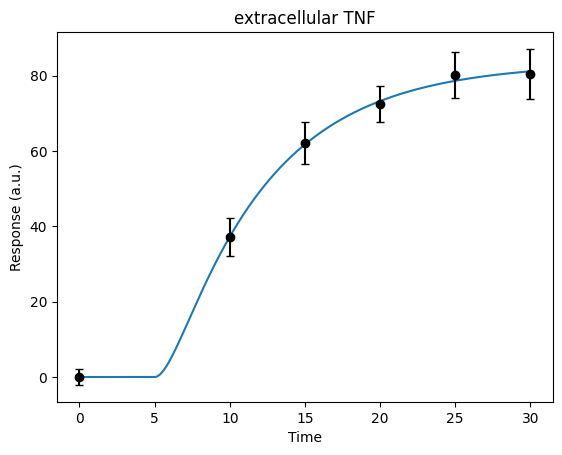

In [8]:
# iterate over all fields in data, and get all time points in the "time" field
all_data_times = sorted(set([t for experiment in data for k,d in data[experiment].items() if "time" in d for t in d["time"] ]))

# Define the objective function (and the log space version of it)
def cost_f(params, sims, data, all_data_times):
    cost = 0
    for experiment in data:
        sims[experiment].Simulate(timevector = all_data_times, resetstatesderivatives=True, parametervalues=params)
        for feature in data[experiment]: 
            if feature != "input":
                sim = sims[experiment].featuredata[:, sims[experiment].featurenames.index(feature)] # Here we should really get only the right datapoints, but we assume that the simulation has the same timepoints as the data
                data_mean = np.array(data[experiment][feature]["mean"])
                data_se = np.array(data[experiment][feature]["se"])
                cost += np.sum(((sim - data_mean)/data_se)**2)
    return cost

def cost_log(params, sims, data, all_data_times):
    return cost_f(np.exp(params), sims, data, all_data_times)

# Define the optimization
args = (sims, data, all_data_times)
x0 = np.log([0.35, 0.3, 0.35, 0.3])
bounds = Bounds([np.log(1e-6)]*len(x0), [np.log(1e6)]*len(x0))

# Run the optimization
result = differential_evolution(cost_log, bounds, args=args, disp=True)
result['x'] = np.exp(result['x']) # transform back from log space

# Get the results of the optimization
cost = cost_f(result['x'], sims, data, all_data_times)
print("Cost:", cost)
print("Parameters:", result['x'])
df = np.sum([np.sum(~np.isnan(data[experiment][feature]["se"])) for experiment in data if experiment!="all_times" for feature in data[experiment] if feature != "input"]) # get the degrees of freedom (df) by getting the total number of all sems in the data that are not NaN
chi2_limit = chi2.ppf(0.95, df)
print(f"Model rejected: {cost > chi2_limit} (rejected if cost={cost} > limit={chi2_limit})")

simulate_and_plot_all_experiments(result['x'], sims, data)

Change the kinetics, can the agreement get better? 

Now we switch the reaction $\varnothing \rightarrow TNF$ to be saturated with respect to $NFKBactive$. This gives us the following updated reaction:

$$ vsynt = k3*NFKBactive \quad \rightarrow \quad vsynt = Vmax*\frac{NFKBactive}{kM + NFKBactive}$$

/home/william/projects/xhide/monocyte_modelling_example/models/simple_TNF_MM.c: In function ‘simple_TNF_MM_initialcondition’:
/home/william/projects/xhide/monocyte_modelling_example/models/simple_TNF_MM.c:90:30: warning: variable ‘k4’ set but not used [-Wunused-but-set-variable]
   90 |         double k1,k2,Vmax,kM,k4;
      |                              ^~
/home/william/projects/xhide/monocyte_modelling_example/models/simple_TNF_MM.c:90:27: warning: variable ‘kM’ set but not used [-Wunused-but-set-variable]
   90 |         double k1,k2,Vmax,kM,k4;
      |                           ^~
/home/william/projects/xhide/monocyte_modelling_example/models/simple_TNF_MM.c:90:22: warning: variable ‘Vmax’ set but not used [-Wunused-but-set-variable]
   90 |         double k1,k2,Vmax,kM,k4;
      |                      ^~~~
/home/william/projects/xhide/monocyte_modelling_example/models/simple_TNF_MM.c:90:19: warning: variable ‘k2’ set but not used [-Wunused-but-set-variable]
   90 |         double

Model 'simple_TNF_MM' succesfully installed.
differential_evolution step 1: f(x)= 42.2914773889447
differential_evolution step 2: f(x)= 42.2914773889447
differential_evolution step 3: f(x)= 42.2914773889447
differential_evolution step 4: f(x)= 41.55892527904308
differential_evolution step 5: f(x)= 22.250279265847944
differential_evolution step 6: f(x)= 22.250279265847944
differential_evolution step 7: f(x)= 22.250279265847944
differential_evolution step 8: f(x)= 19.888891276405403
differential_evolution step 9: f(x)= 19.888891276405403
differential_evolution step 10: f(x)= 19.888891276405403
differential_evolution step 11: f(x)= 19.888891276405403
differential_evolution step 12: f(x)= 19.888891276405403
differential_evolution step 13: f(x)= 19.888891276405403
differential_evolution step 14: f(x)= 19.888891276405403
differential_evolution step 15: f(x)= 19.888891276405403
differential_evolution step 16: f(x)= 19.888891276405403
differential_evolution step 17: f(x)= 8.406228884315453
dif

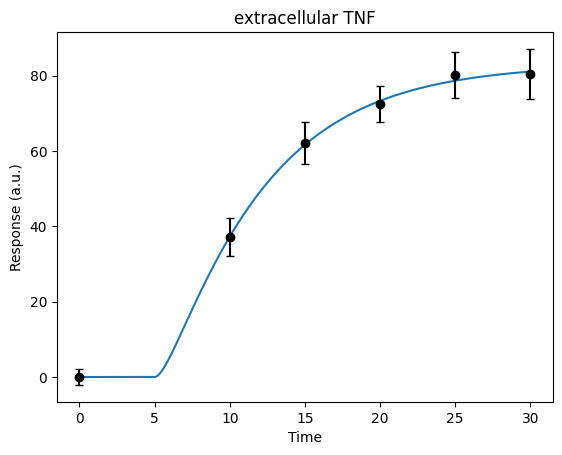

In [9]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple_TNF_MM.txt')
Simple_TNF_MM = sund.importModel('simple_TNF_MM')
simple_TNF_MM = Simple_TNF_MM() # get the object from the model class

# Setup the simulations
sims = create_sims_from_data(simple_TNF_MM, data)

# Define the optimization
args = (sims, data, all_data_times)
x0 = np.log([0.35, 0.3, 0.35, 0.3, 0.3])
bounds = Bounds([np.log(1e-6)]*len(x0), [np.log(1e6)]*len(x0))

# Run the optimization
result = differential_evolution(cost_log, bounds, args=args, disp=True)
result['x'] = np.exp(result['x']) # transform back from log space

# Get the results of the optimization
cost = cost_f(result['x'], sims, data, all_data_times)
print("Cost:", cost)
print("Parameters:", result['x'])
df = np.sum([np.sum(~np.isnan(data[experiment][feature]["se"])) for experiment in data if experiment!="all_times" for feature in data[experiment] if feature != "input"]) # get the degrees of freedom (df) by getting the total number of all sems in the data that are not NaN
chi2_limit = chi2.ppf(0.95, df)
print(f"Model rejected: {cost > chi2_limit} (rejected if cost={cost} > limit={chi2_limit})")

simulate_and_plot_all_experiments(result['x'], sims, data)

The need for a more complex model. 

Let the students implement a model that they themselves have put together. 
(should there be a hand in of the suggested map before they do this?)

Let the students implement the fully complex model (the published one).

Make predictions of a new experiment 
(perhaps dual stimulation, and compare to some "blue model" data?)

The exercise is over here, below is just for rendering the picture

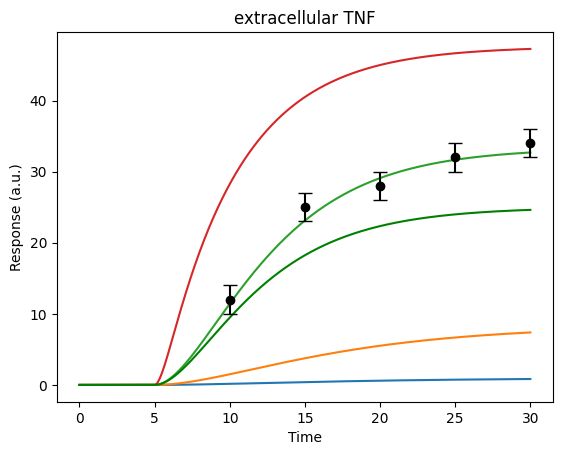

In [17]:
# This section is only for plotting the figure needed in the presentation, and should be removed later. 

def simulate_and_plot_doses(model, time, params=[1,2]):
    plt.figure()
    for LPS in [0.01, 0.1, 1, 10]:
        stimulation_activity = sund.Activity(timeunit='m')
        stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'LPS', tvalues = [5], fvalues = [0, LPS])
        simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
        simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=params)
        feature_data = simulation.featuredata_dict()
        feature_data["time"] = simulation.timevector

        plot_feature(feature_data, "extracellular TNF")

    stimulation_activity = sund.Activity(timeunit='m')
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'LPS', tvalues = [5], fvalues = [0, 1])
    simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
    simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=[0.3, 0.06, 0.06, 0.2])
    feature_data = simulation.featuredata_dict()
    feature_data["time"] = simulation.timevector

    plt.plot(feature_data['time'], feature_data["extracellular TNF"], color='g')
    plt.errorbar([10, 15, 20, 25, 30],[12, 25, 28, 32, 34],[2,2,2,2,2], fmt='o', color='k', capsize=5)

    # plt.savefig("doses.svg")

simulate_and_plot_doses(simple_TNF, time, params=[0.2, 0.1, 0.1, 0.2]) #params = results['x']